In [68]:
import numpy as np
import pandas as pd
import scipy
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df_seg = pd.read_csv('segmentation data.csv', index_col=0)

In [3]:
df_seg.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [4]:
df_seg.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


## Correlation Estimate

In [5]:
df_seg.corr()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Sex,1.000000,0.566511,-0.182885,0.244838,-0.195146,-0.202491,-0.300803
Marital status,0.566511,1.000000,-0.213178,0.374017,-0.073528,-0.029490,-0.097041
Age,-0.182885,-0.213178,1.000000,0.654605,0.340610,0.108388,0.119751
Education,0.244838,0.374017,0.654605,1.000000,0.233459,0.064524,0.034732
Income,-0.195146,-0.073528,0.340610,0.233459,1.000000,0.680357,0.490881
Occupation,-0.202491,-0.029490,0.108388,0.064524,0.680357,1.000000,0.571795
Settlement size,-0.300803,-0.097041,0.119751,0.034732,0.490881,0.571795,1.000000


- Strong linear postive correlation between age and eduction
- Same between income and occupation
- Same between Settlement size and occupation

Let's make it more visual : 

Text(0.5, 1.0, 'Correlation Heatmap')

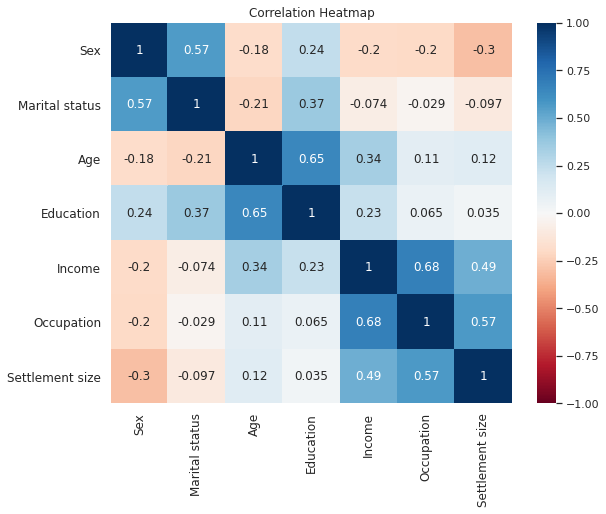

In [6]:
plt.figure(figsize=(9, 7))
s = sns.heatmap(df_seg.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1)
s.set_yticklabels(s.get_yticklabels(), rotation=0, fontsize=12)
s.set_xticklabels(s.get_xticklabels(), rotation=90, fontsize=12)
plt.title('Correlation Heatmap')

Exploring correlations between customer features is the essence of customer segmentation

## DataViz

Text(0.5, 1.0, 'Age vs Income')

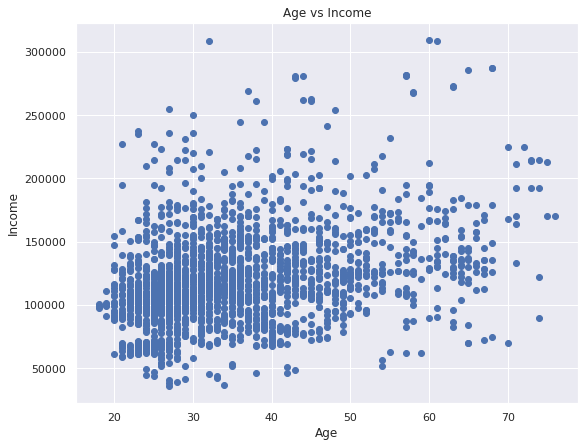

In [7]:
plt.figure(figsize=(9, 7))
plt.scatter(df_seg.iloc[:, 2], df_seg.iloc[:, 4])
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Age vs Income')

## Standardization

In [8]:
scaler = StandardScaler()
seg_std = scaler.fit_transform(df_seg)

In [9]:
seg_std

array([[-0.91739884, -0.99302433,  2.65361447, ...,  0.09752361,
         0.29682303,  1.552326  ],
       [ 1.09003844,  1.00702467, -1.18713209, ...,  0.78265438,
         0.29682303,  1.552326  ],
       [-0.91739884, -0.99302433,  1.11731585, ..., -0.83320224,
        -1.26952539, -0.90972951],
       ...,
       [-0.91739884, -0.99302433, -0.41898277, ..., -0.90695688,
        -1.26952539, -0.90972951],
       [ 1.09003844,  1.00702467, -1.01643224, ..., -0.60332923,
        -1.26952539, -0.90972951],
       [-0.91739884, -0.99302433, -0.93108232, ..., -1.3789866 ,
        -1.26952539, -0.90972951]])

## Hierarchical vs Flat Clustering

In Hierarchical, there is : 
- top-down (divisive)
- agglomerative (bottom-up)

We can use the euclidian distance, manhattan distance or others to measure difference between observations. We must also calculate the distance between clusters, to do so we use the Ward method.

In [10]:
# returning a linkage matrix
hier_clust = linkage(seg_std, method='ward')

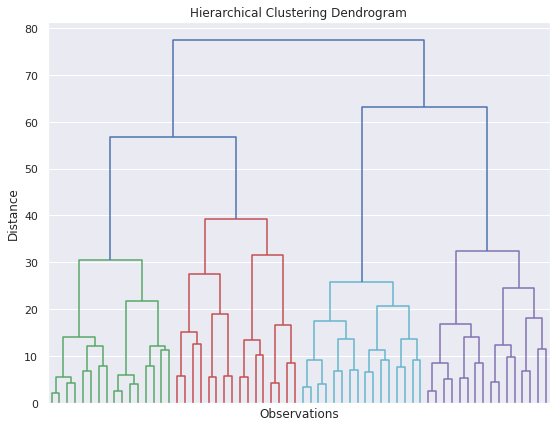

In [11]:
plt.figure(figsize=(9, 7))
plt.xlabel('Observations')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(hier_clust, truncate_mode='level', p=5,
           show_leaf_counts=False, no_labels=True)
plt.show()

To know where to cut the dendrogram, a rule of thumb is to find the longest vertical line unintercepted by a horizontal one. But most often, business knowledge is of a great help. Here we can find 4 clusters. Actually the linkage matrix from scipy do it for us.

With bigger datasets, hierarchical clustering takes more time for this reason, we often use flat clustering for the actual job. 

## K-means

Limitations :
- clusters initialization and value of K should be determinated using business knowledge
- it's sensitive to outliers --> making use of K-medians
- it works poorly for elongated clusters --> DBSCAN

In [12]:
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(seg_std)
    wcss.append(kmeans.inertia_)

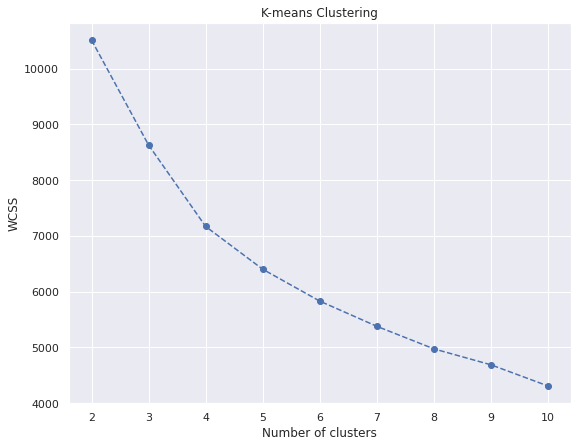

In [13]:
plt.figure(figsize=(9, 7))
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.plot(range(2,11), wcss, marker='o', linestyle='--')
plt.show()

We can spot an elbow around the 4th cluster, it's similar to hierarchical clustering results.

In [14]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(seg_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

## Results

In [15]:
seg_kmeans = df_seg.copy()
seg_kmeans['Segment K-means'] = kmeans.labels_

In [16]:
seg_analysis = seg_kmeans.groupby(['Segment K-means']).mean()
seg_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment K-means,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290
2,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807
3,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695


In [17]:
# we include an arbitrary second column in order to be able to count each row in the table
seg_analysis['Nb Obs'] = seg_kmeans[['Segment K-means', 'Sex']].groupby(['Segment K-means']).count()
seg_analysis['% Obs'] = seg_analysis['Nb Obs']/seg_analysis['Nb Obs'].sum()

In [19]:
seg_analysis.rename({0:'well-off',
                   1:'fewer-opportunities',
                   2: 'standard',
                   3: 'career focused'})

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Nb Obs,% Obs
Segment K-means,,,,,,,,,
well-off,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
fewer-opportunities,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
standard,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850
career focused,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525


In [20]:
seg_kmeans['Labels'] = seg_kmeans['Segment K-means'].map({0:'well-off',
                   1:'fewer-opportunities',
                   2: 'standard',
                   3: 'career focused'})

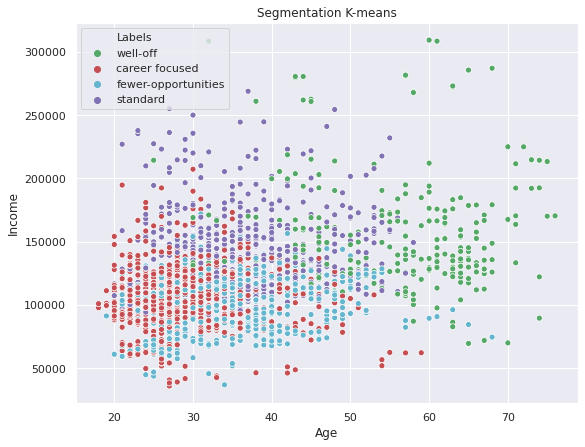

In [21]:
x_axis = seg_kmeans['Age']
y_axis = seg_kmeans['Income']
plt.figure(figsize=(9, 7))
sns.scatterplot(x_axis, y_axis, hue=seg_kmeans['Labels'], palette=['g','r','c','m'])
plt.title('Segmentation K-means');

## PCA

In [23]:
pca = PCA()
pca.fit(seg_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [28]:
pca.explained_variance_ratio_

array([0.35696328, 0.26250923, 0.18821114, 0.0755775 , 0.05716512,
       0.03954794, 0.02002579])

Three components explain around 80% of the variance in the data

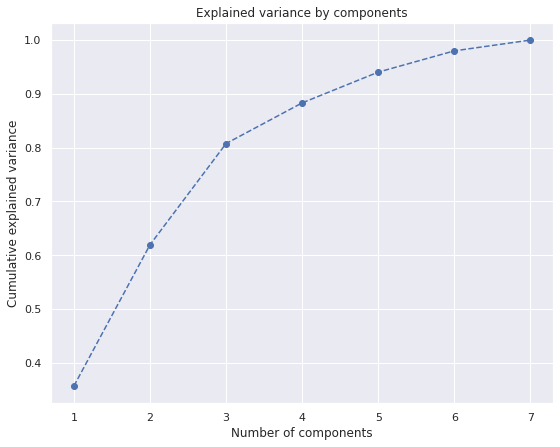

In [29]:
plt.figure(figsize=(9, 7))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance by components')
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.show()

Here, i keep 4 components, this allowing to retain about 90% of the information.

In [30]:
pca = PCA(n_components=4)
pca.fit(seg_std)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [31]:
pca.components_

array([[-0.31469524, -0.19170439,  0.32609979,  0.15684089,  0.52452463,
         0.49205868,  0.46478852],
       [ 0.45800608,  0.51263492,  0.31220793,  0.63980683,  0.12468314,
         0.01465779, -0.06963165],
       [-0.29301261, -0.44197739,  0.60954372,  0.27560461, -0.16566231,
        -0.39550539, -0.29568503],
       [-0.31560091,  0.28045392, -0.00950602,  0.18147643, -0.48260023,
        -0.28169039,  0.69026455]])

Loadings are correlation between original variables and components.

In [32]:
df_pca = pd.DataFrame(data=pca.components_, columns=df_seg.columns.values, index=[
                      'pc1', 'pc2', 'pc3', 'pc4'])
df_pca

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
pc1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
pc2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
pc3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685
pc4,-0.315601,0.280454,-0.009506,0.181476,-0.482600,-0.281690,0.690265


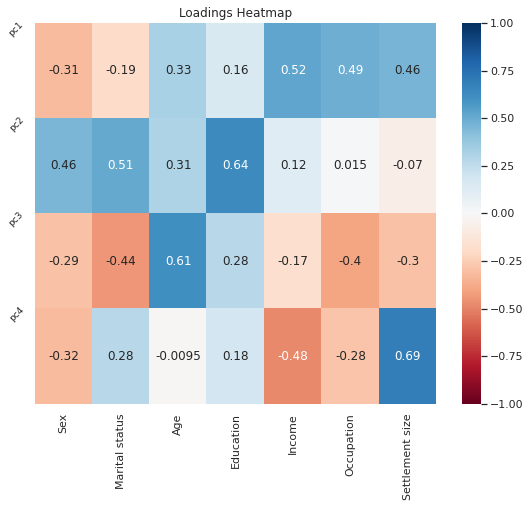

In [41]:
plt.figure(figsize=(9, 7))
sns.heatmap(df_pca, annot=True, cmap='RdBu', vmin=-1, vmax=1)
plt.yticks([0, 1, 2, 3], ['pc1', 'pc2', 'pc3', 'pc4'], rotation=45, fontsize=9)
plt.title('Loadings Heatmap')

Pc1 shows carrer focused people, pc2 refers more to education and lifestyle and pc3 is related to experience (work or life)...

Now we transform original data into the desired PCA based dataset.

In [42]:
seg_pca = pca.transform(seg_std)

## K-Means Clustering based on PCA

In [43]:
wcss = []
for i in range(2, 11):
    pca_kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    pca_kmeans.fit(seg_pca)
    wcss.append(pca_kmeans.inertia_)

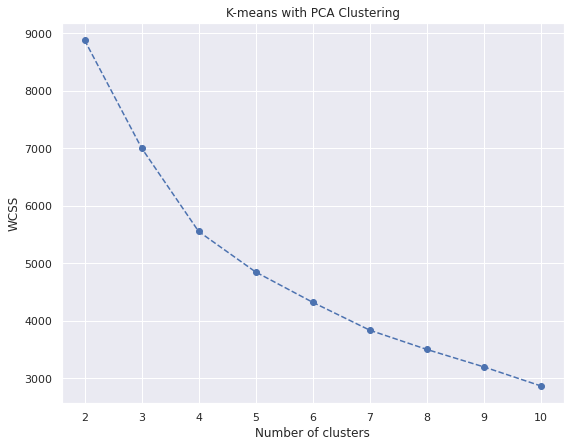

In [44]:
plt.figure(figsize=(9, 7))
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.plot(range(2,11), wcss, marker='o', linestyle='--')
plt.show()

Here we still choose 4 clusters, but the WCSS is lower.

In [51]:
pca_kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
pca_kmeans.fit(seg_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

## PCA based K-means Results

In [59]:
df_pca_kmeans = pd.concat([df_seg.reset_index(drop=True), pd.DataFrame(seg_pca)], axis=1)
df_pca_kmeans.columns.values[-4:] = ['pc1 / career', 'pc2 / edu-life', 'pc3 / exp', 'pc4 / big city']
df_pca_kmeans['Seg K-means PCA'] = pca_kmeans.labels_
df_pca_kmeans.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,pc1 / career,pc2 / edu-life,pc3 / exp,pc4 / big city,Seg K-means PCA
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,1.217794,0
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,0.548385,3
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,0.120675,2
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,-0.510753,1
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,-0.231808,1


In [60]:
seg_analysis_pca = df_pca_kmeans.groupby(['Seg K-means PCA']).mean()
seg_analysis_pca

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,pc1 / career,pc2 / edu-life,pc3 / exp,pc4 / big city
Seg K-means PCA,,,,,,,,,,,
0,0.503788,0.689394,55.689394,2.128788,158209.094697,1.125000,1.106061,1.697646,2.029427,0.841953,0.093869
1,0.026178,0.178010,35.624782,0.734729,140950.319372,1.267016,1.520070,1.381089,-1.044848,-0.273292,0.211736
2,0.319018,0.089980,35.259714,0.768916,95850.155419,0.296524,0.038855,-0.987777,-0.882022,0.965476,-0.271684
3,0.905045,0.986647,28.873887,1.063798,107576.228487,0.672107,0.439169,-1.122432,0.733291,-0.797918,-0.019662


In [61]:
# we include an arbitrary second column in order to be able to count each row in the table
seg_analysis_pca['Nb Obs'] = df_pca_kmeans[[
    'Seg K-means PCA', 'Sex']].groupby(['Seg K-means PCA']).count()
seg_analysis_pca['% Obs'] = seg_analysis_pca['Nb Obs'] / \
    seg_analysis_pca['Nb Obs'].sum()
seg_analysis_pca = seg_analysis_pca.rename({0: 'well-off',
                                            1: 'career focused',
                                            2: 'fewer-opportunities',
                                            3: 'standard'})
seg_analysis_pca

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,pc1 / career,pc2 / edu-life,pc3 / exp,pc4 / big city,Nb Obs,% Obs
Seg K-means PCA,,,,,,,,,,,,,
well-off,0.503788,0.689394,55.689394,2.128788,158209.094697,1.125000,1.106061,1.697646,2.029427,0.841953,0.093869,264,0.1320
career focused,0.026178,0.178010,35.624782,0.734729,140950.319372,1.267016,1.520070,1.381089,-1.044848,-0.273292,0.211736,573,0.2865
fewer-opportunities,0.319018,0.089980,35.259714,0.768916,95850.155419,0.296524,0.038855,-0.987777,-0.882022,0.965476,-0.271684,489,0.2445
standard,0.905045,0.986647,28.873887,1.063798,107576.228487,0.672107,0.439169,-1.122432,0.733291,-0.797918,-0.019662,674,0.3370


In [62]:
df_pca_kmeans['Labels'] = df_pca_kmeans['Seg K-means PCA'].map({0: 'well-off',
                                                                1: 'career focused',
                                                                2: 'fewer-opportunities',
                                                                3: 'standard'})

### Plot Data by PCA Components 1 and 2

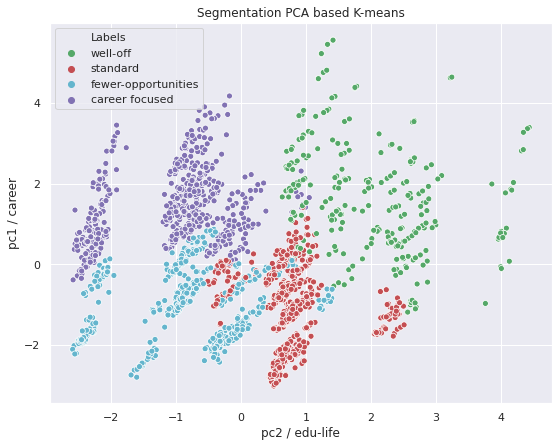

In [63]:
y_axis = df_pca_kmeans['pc1 / career']
x_axis = df_pca_kmeans['pc2 / edu-life']
plt.figure(figsize=(9, 7))
sns.scatterplot(x_axis, y_axis, hue=df_pca_kmeans['Labels'], palette=['g','r','c','m'])
plt.title('Segmentation PCA based K-means');

The division based on components is much better, we reduce the number of variables into meaningful features.

### Plot Data by PCA Components 1 and 3

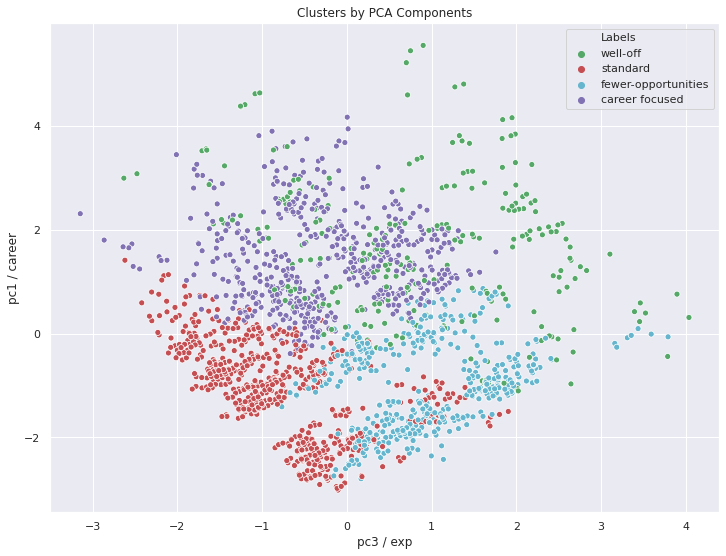

In [66]:
x_axis_1 = df_pca_kmeans['pc3 / exp']
y_axis_1 = df_pca_kmeans['pc1 / career']
plt.figure(figsize = (12, 9))
sns.scatterplot(x_axis_1, y_axis_1, hue = df_pca_kmeans['Labels'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components' )
plt.show()

### Plot Data by PCA Components 2 and 3

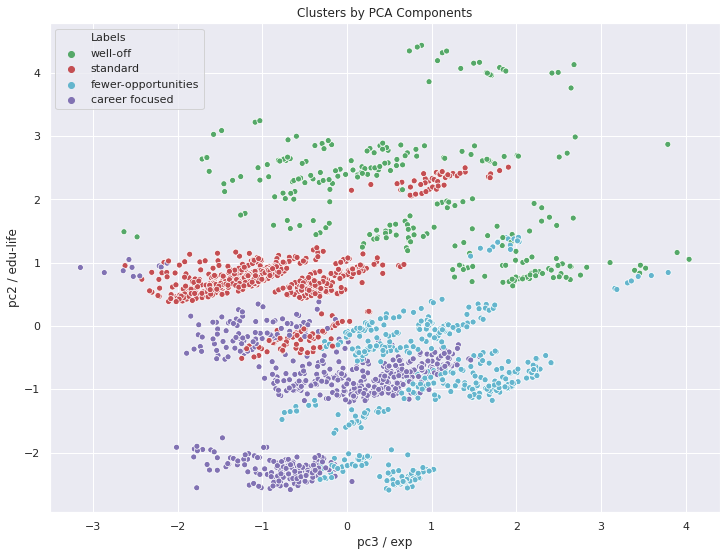

In [67]:
x_axis_1 = df_pca_kmeans['pc3 / exp']
y_axis_1 = df_pca_kmeans['pc2 / edu-life']
plt.figure(figsize = (12, 9))
sns.scatterplot(x_axis_1, y_axis_1, hue = df_pca_kmeans['Labels'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components' )
plt.show()

## Data export

We need to save : 
- the scaler 
- the PCA method
- the k-means with PCA


In [69]:
pickle.dump(scaler, open("scaler.pickle", "wb"))
pickle.dump(pca, open("pca.pickle", "wb"))
pickle.dump(pca_kmeans, open("pca_kmeans.pickle", "wb"))